# IMPORTS

In [24]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

import joblib

# Load the Data

In [2]:
file_path = "Dataset/Android_Permission.csv"
df = pd.read_csv(file_path)
df.head()

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S),Class
0,Canada Post Corporation,com.canadapost.android,Business,Canada Post Mobile App gives you access to som...,3.1,77,0.00,"{com.adaffix.pub.ca.android, com.kevinquan.gas...",7.0,1,...,0,1,0,0,0,0,0,1,0,0
1,Word Farm,com.realcasualgames.words,Brain & Puzzle,Speed and strategy combine in this exciting wo...,4.3,199,0.00,"{air.com.zubawing.FastWordLite, com.joybits.do...",3.0,2,...,0,0,0,0,0,0,0,0,0,0
2,Fortunes of War FREE,fortunesofwar.free,Cards & Casino,"Fortunes of War is a fast-paced, easy to learn...",4.1,243,0.00,"{com.kevinquan.condado, hu.monsta.pazaak, net....",1.0,1,...,0,0,0,0,0,0,0,0,0,0
3,Better Keyboard: Avatar Purple,com.cc.betterkeyboard.skins.avatarpurple,Libraries & Demo,Skin for Better Keyboard featuring a glossy fe...,3.6,2589,0.00,{eu.gdumoulin.betterandroid.skins.transparent....,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,Boxing Day,indiaNIC.android.BoxingDay,Lifestyle,Boxing Day by Christopher Jaymes<p>Based on a ...,0.0,0,5.99,NaN,1.0,0,...,0,0,0,0,0,0,0,0,0,1


# Cleaning

## Shape & missing values

In [3]:
df.shape

(29999, 184)

In [4]:
df.isnull().sum().sort_values(ascending=False).head(10)

Related apps                                                755
Dangerous permissions count                                 204
Description                                                   3
App                                                           1
System tools : set wallpaper size hints (S)                   0
System tools : read sync statistics (S)                       0
System tools : read/write to resources owned by diag (S)      0
System tools : reorder running applications (D)               0
System tools : retrieve running applications (D)              0
System tools : send package removed broadcast (S)             0
dtype: int64

## Drop rows where target is missing

In [5]:
df = df.dropna(subset=['Class'])

## Fill missing numeric values

In [6]:
num_cols = df.select_dtypes(include=['int64','float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

## Fill missing text fields

In [7]:
text_cols = df.select_dtypes(include=['object']).columns
df[text_cols] = df[text_cols].fillna("Unknown")

# EDA

## Dangerous permissions distribution

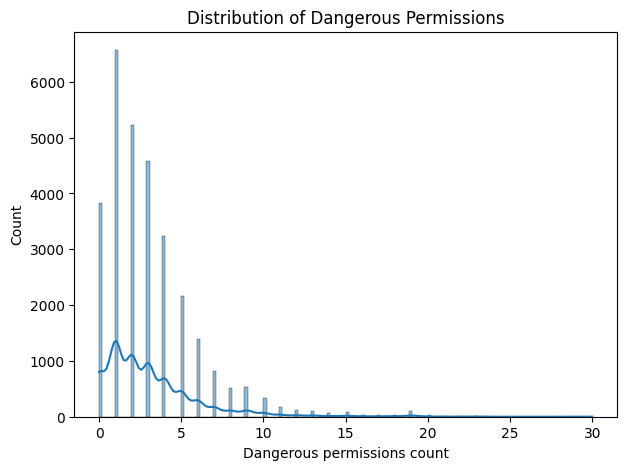

In [8]:
plt.figure(figsize=(7,5))
sns.histplot(df['Dangerous permissions count'], kde=True)
plt.title("Distribution of Dangerous Permissions")
plt.show()

## App categories by risk

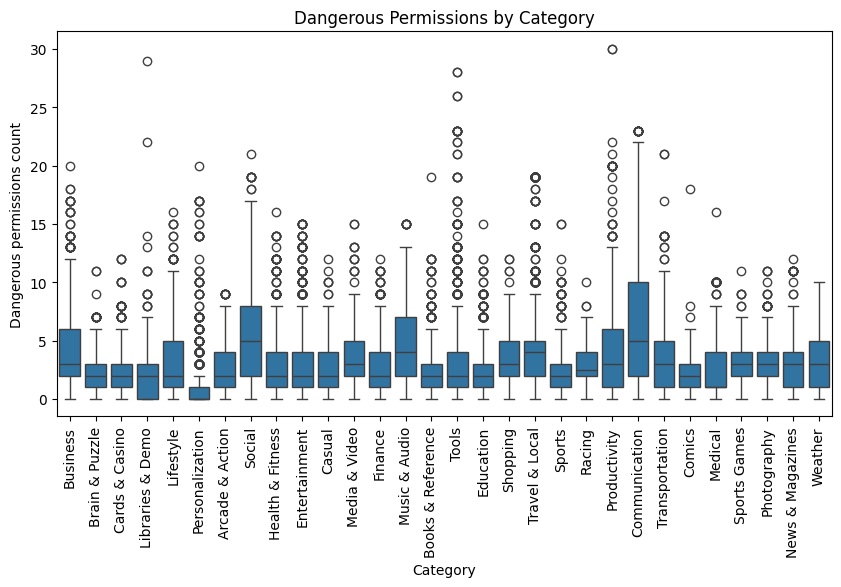

In [9]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="Category", y="Dangerous permissions count")
plt.xticks(rotation=90)
plt.title("Dangerous Permissions by Category")
plt.show()

## Correlation heatmap

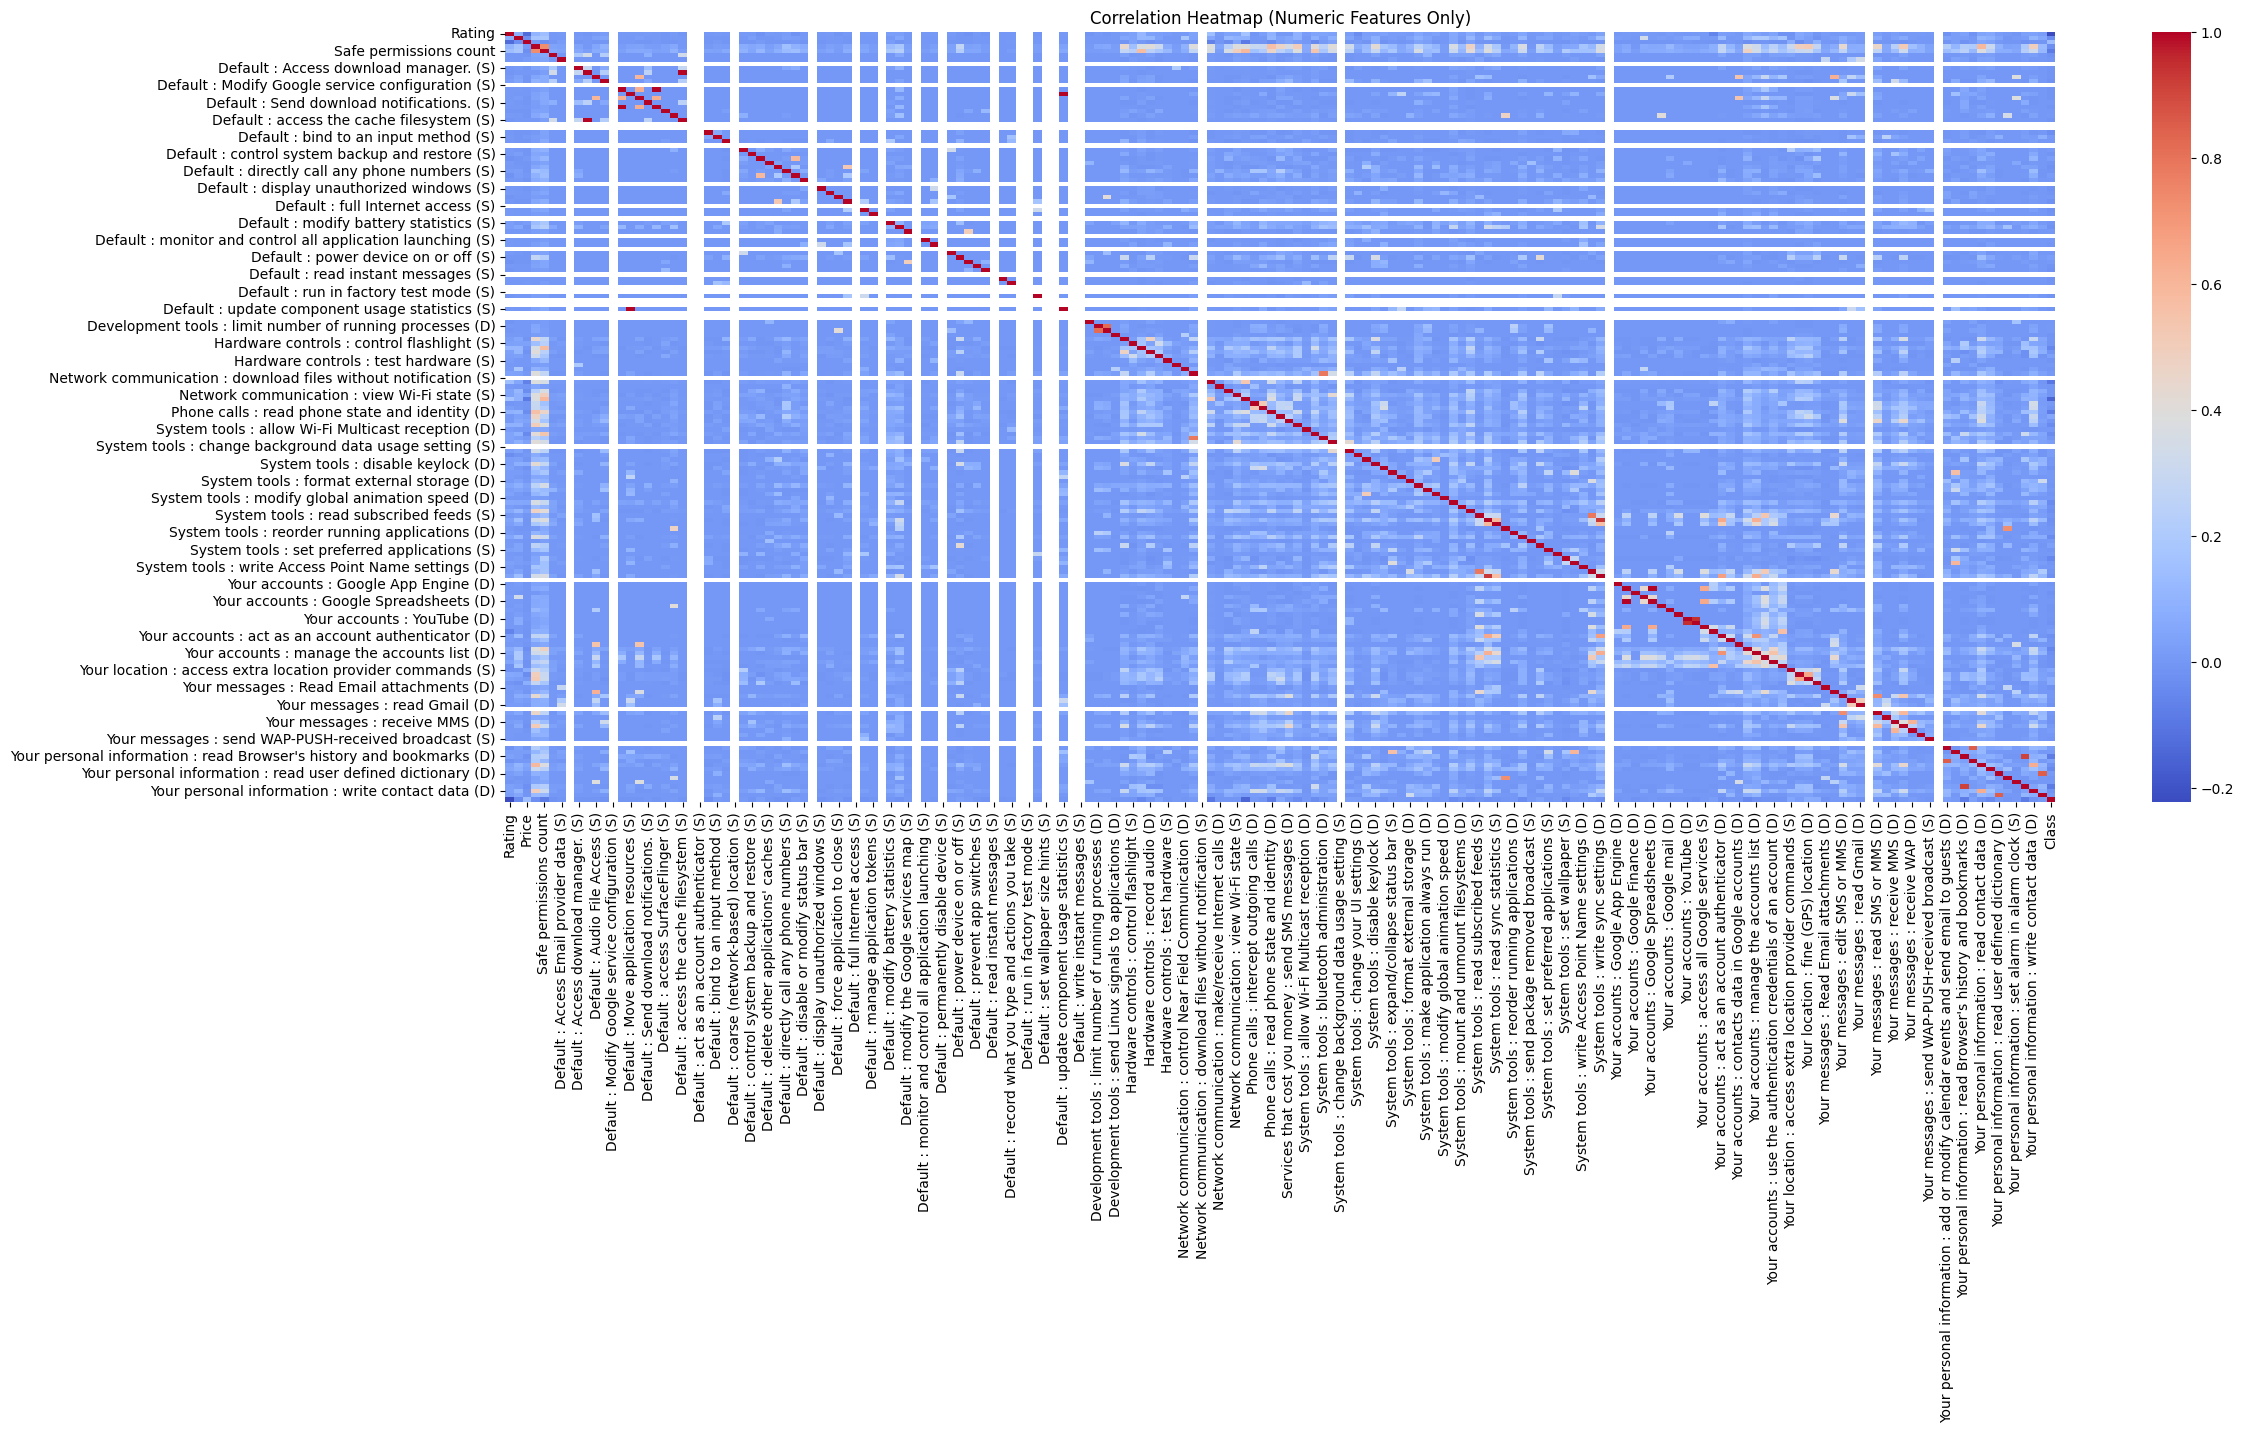

In [12]:
plt.figure(figsize=(25,10))
numeric_df = df.select_dtypes(include=['int64','float64'])
sns.heatmap(numeric_df.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()

# Feature Engineering

## Binary-encoding each permission column

In [13]:
# Extract permission columns
permission_cols = [col for col in df.columns if "(S)" in col or "(D)" in col]

# Convert to binary (0/1) if not already
for col in permission_cols:
    df[col] = df[col].apply(lambda x: 1 if x>0 else 0)

## Encode categorical columns

In [14]:
df['Category'] = df['Category'].astype('category').cat.codes
df['Price'] = df['Price'].replace('$','', regex=True).astype(float)
df['Class'] = df['Class'].astype('category').cat.codes   # 0/1/2

# Define Features & Target

In [15]:
X = df.drop(columns=['App','Package','Description','Related apps','Class'])
y = df['Class']

print(X.shape, y.shape)

(29999, 179) (29999,)


# Train/Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train ML Model

In [18]:
# Random Forest
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    random_state=42
)

model.fit(X_train_scaled, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# Evaluation

Accuracy: 0.8035

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.75      0.72      2000
           1       0.87      0.83      0.85      4000

    accuracy                           0.80      6000
   macro avg       0.78      0.79      0.78      6000
weighted avg       0.81      0.80      0.81      6000



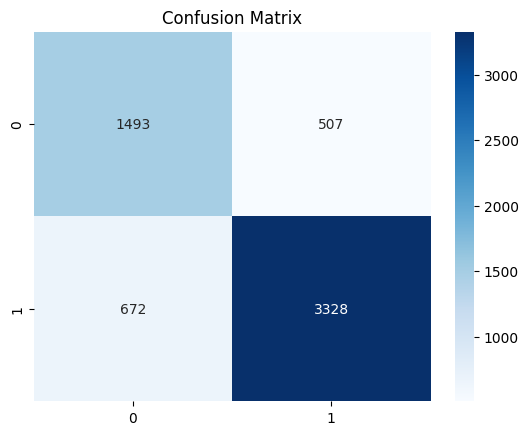

In [19]:
y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Feature Importance

In [21]:
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

importances.head(20)

,feature,importance
2,Number of ratings,0.271459
0,Category,0.212518
3,Price,0.132220
1,Rating,0.102466
4,Dangerous permissions count,0.027822
5,Safe permissions count,0.024672
86,Network communication : view network state (S),0.016342
151,Your location : fine (GPS) location (D),0.013568
89,Phone calls : read phone state and identity (D),0.009041
92,Storage : modify/delete USB storage contents m...,0.008268


# Save the Model for Deployment

In [27]:
os.makedirs("Model", exist_ok=True)
joblib.dump(model, "Model/privacy_risk_model.pkl")
joblib.dump(scaler, "Model/scaler.pkl")

['Model/scaler.pkl']